<h2> Drug Review Sentiment Analysis

**Overview**

**1. Problem Formulation**
* Context
  * Data source and social significance
* Goal and task of the project

**2. EDA and Data Cleaning**
* Exploratory Data Analysis:
    * Data distributions
    * Frequent words
* Data Cleaning:
    * Remove invalid data
    * Balance the dataset
    * Pre-process review text

**3. Modeling and Evaluations**
* Models
  * Logistic Regression
  * Multinomial Naive Bayes
  * SGDClassifier
  * Recurrent Neural Network
* Evaluations and Error Analysis
  * Classification report
  * ROC curve
  * Confusion matrix

**4. Evaluation Summary and Conclusions**

<h3> 1. Problem Formulation </h3>

* Context: This project is a sentiment analysis machine learning project on drug reviews. 
  * The source of these reviews is a repository of over 210,000 drug reviews. Since the dataset is too large, I randomly chose a portion of the training data for the project.
  * Dataset: https://www.kaggle.com/datasets/jessicali9530/kuc-hackathon-winter-2018
  * The data was originally from the paper "Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data Learning." This dataset was used for the Winter 2018 Kaggle University Club Hackathon. Although the authors acknowledge that the dataset is for NLP learning purposes, the data can still give us some insights in relationships between language and emotions and potentially applicable in real-life scenarios, such as analyzing public demand for particular drugs and assisting individuals in making informed decisions when selecting drugs.
* Goal: To predict users' sentiment towards drugs based on their review content. 
* Task: Binary classification of sentiments (positive or negative) based on user reviews on drugs. Each row contains an instance of a person's review and their rating of a drug.


In [1]:
# Import libraries and packages used in the code
import pandas as pd
import numpy as np
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from scipy.special import expit

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

I selected columns drug name, condition, review, and rating as the features to explore as I think they are the most relevant features.

In [2]:
df = pd.read_csv('drugsComTrain_raw.csv', usecols=[1, 2, 3, 4])
df.head()

,drugName,condition,review,rating
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9


In [3]:
df.shape

(161297, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   drugName   161297 non-null  object
 1   condition  160398 non-null  object
 2   review     161297 non-null  object
 3   rating     161297 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 4.9+ MB


<h3> 2. EDA and Data Cleaning

<h4> 2.1 Exploratory Data Analysis

2.1.1 Explorations on continuous/ordinal variables

##### Looking at drug names:

In [5]:
df['drugName'].value_counts().head(10)

Levonorgestrel                        3657
Etonogestrel                          3336
Ethinyl estradiol / norethindrone     2850
Nexplanon                             2156
Ethinyl estradiol / norgestimate      2117
Ethinyl estradiol / levonorgestrel    1888
Phentermine                           1543
Sertraline                            1360
Escitalopram                          1292
Mirena                                1242
Name: drugName, dtype: int64

##### Looking at conditions

In [6]:
df['condition'].unique()[0:10]

array(['Left Ventricular Dysfunction', 'ADHD', 'Birth Control',
       'Opiate Dependence', 'Benign Prostatic Hyperplasia',
       'Emergency Contraception', 'Bipolar Disorde', 'Epilepsy',
       'Migraine Prevention', 'Depression'], dtype=object)

In [7]:
df['condition'].value_counts().head(10)

Birth Control      28788
Depression          9069
Pain                6145
Anxiety             5904
Acne                5588
Bipolar Disorde     4224
Insomnia            3673
Weight Loss         3609
Obesity             3568
ADHD                3383
Name: condition, dtype: int64

##### Look at ratings

In [8]:
df['rating'].value_counts()

10    50989
9     27531
1     21619
8     18890
7      9456
5      8013
2      6931
3      6513
6      6343
4      5012
Name: rating, dtype: int64

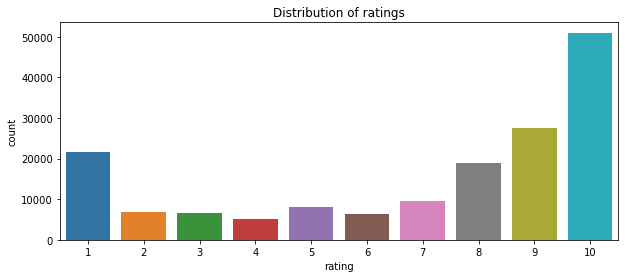

In [9]:
plt.rcParams['figure.figsize'] = [10, 4]
sns_rate = sns.countplot(x='rating', data=df)
plt.title('Distribution of ratings')
plt.show()

We can see from the count plot that the most common ratings are 10, 9, and 1, which means ratings are polarized and people tend to either like the drugs very much or not like it at all.

Examples of drugs with highest and lowest ratings

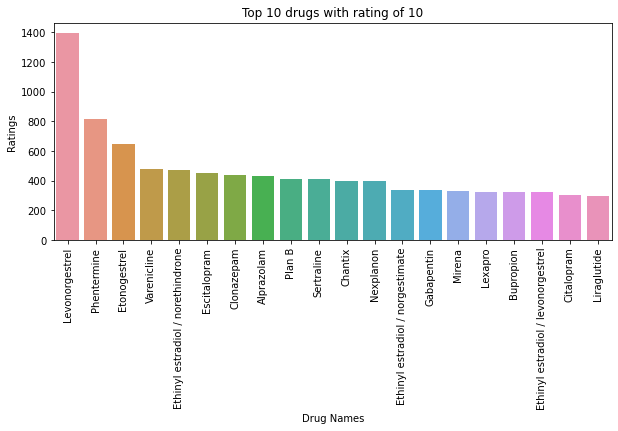

In [10]:
# Visualize the top 10 drugs with rating of 10
top_drugnames = dict(df[df['rating'] == 10]['drugName'].value_counts())
sns_rating = sns.barplot(x = list(top_drugnames.keys())[0:20], y = list(top_drugnames.values())[0:20])
sns_rating.set(title = 'Top 10 drugs with rating of 10', ylabel = 'Ratings', xlabel = "Drug Names")
plt.xticks(rotation=90)
plt.show()

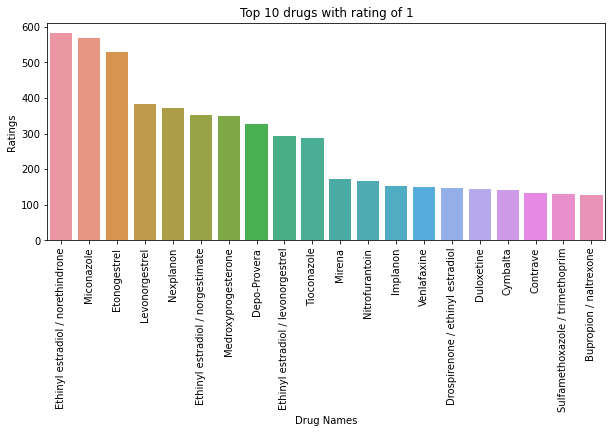

In [11]:
# Visualize the top 10 drugs with rating of 1
top_drugnames = dict(df[df['rating'] == 1]['drugName'].value_counts())
sns_rating = sns.barplot(x = list(top_drugnames.keys())[0:20], y = list(top_drugnames.values())[0:20])
sns_rating.set(title = 'Top 10 drugs with rating of 1', ylabel = 'Ratings', xlabel = "Drug Names")
plt.xticks(rotation=90)
plt.show()

We can observe that some popular drugs often have a large number of both positive and negative ratings, which means those drugs, although most often used, may not work well for most people.

Examples of conditions with highest and lowest ratings

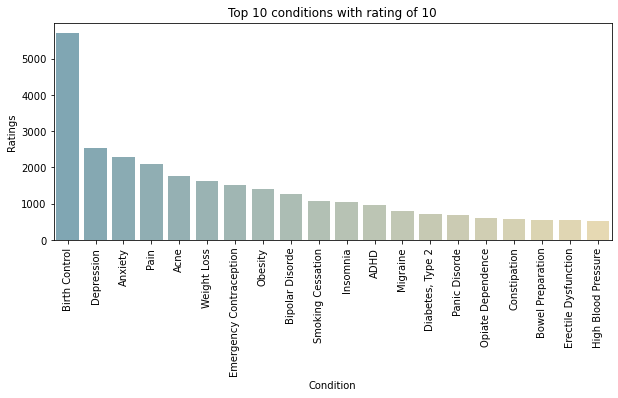

In [12]:
# Visualize the top 10 drugs with rating of 10
top_drugnames = dict(df[df['rating'] == 10]['condition'].value_counts())
sns_rating = sns.barplot(x = list(top_drugnames.keys())[0:20], y = list(top_drugnames.values())[0:20], palette='blend:#7AB,#EDA')
sns_rating.set(title = 'Top 10 conditions with rating of 10', ylabel = 'Ratings', xlabel = "Condition")
plt.xticks(rotation=90)
plt.show()

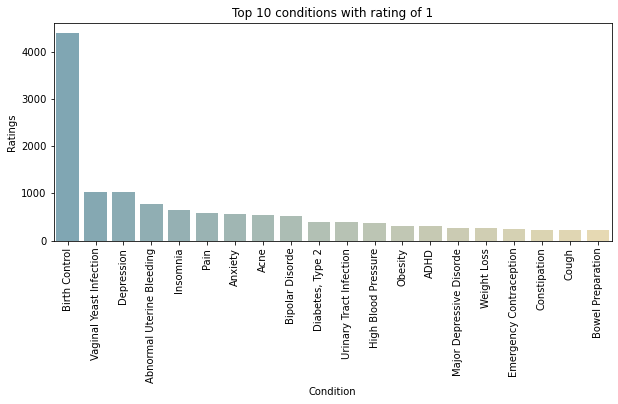

In [13]:
# Visualize the top 10 drugs with rating of 1
top_drugnames = dict(df[df['rating'] == 1]['condition'].value_counts())
sns_rating = sns.barplot(x = list(top_drugnames.keys())[0:20], y = list(top_drugnames.values())[0:20], palette='blend:#7AB,#EDA')
sns_rating.set(title = 'Top 10 conditions with rating of 1', ylabel = 'Ratings', xlabel = "Condition")
plt.xticks(rotation=90)
plt.show()

Similar to drugs, most common illness conditions are often the ones with the most positive or negative ratings. Interestingly, in the top 10 conditions with the worst rating, some conditions are not the most popular ones, including conditions usually occur on female bodies, such as "Vaginal yeast infection" and "Abnormal uterine bleeding".

2.1.2 Explorations on text and 

Look at sentiment classes

Create a new column to classify sentiment
* positive: 6 < rating <= 10
* neutral: 4 < rating <= 6
* negative: 1 <= rating <= 4

In [14]:
df['sentiment'] = np.where(df['rating'] <= 4, 'negative', np.where(df['rating'] <= 6, 'neutral', 'positive'))
df.head()

,drugName,condition,review,rating,sentiment
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,positive
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,positive
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,neutral
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,positive
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,positive


In [15]:
df['sentiment'].value_counts()

positive    106866
negative     40075
neutral      14356
Name: sentiment, dtype: int64

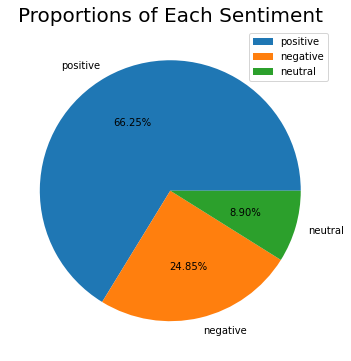

In [16]:
# Visualize the portions of each sentiment

sentiments = df['sentiment'].value_counts()
labels = sentiments.index
counts = sentiments.values

plt.rcParams['figure.figsize'] = (6, 6)
plt.pie(counts, labels = labels, autopct = '%.2f%%')
plt.title('Proportions of Each Sentiment', fontsize = 20)
plt.legend(loc='upper right')
plt.show()

The dataset is not equally distributed as it contains a high proportion of positive reviews. Neutral samples are the rarest, which are only less than 9 percent of the data, while the postive class are over 60 percent. In later data cleaning, I'm going to drop neutral class and downsample the positive class to balance the data. The reason I need a balanced dataset is because the models will not learn well on the class with fewer samples and thus result in biased models.

In [17]:
df['length'] = df['review'].apply(len) # number of characters
df['length'].describe() 

count    161297.000000
mean        458.726238
std         242.130235
min           3.000000
25%         262.000000
50%         455.000000
75%         691.000000
max       10787.000000
Name: length, dtype: float64

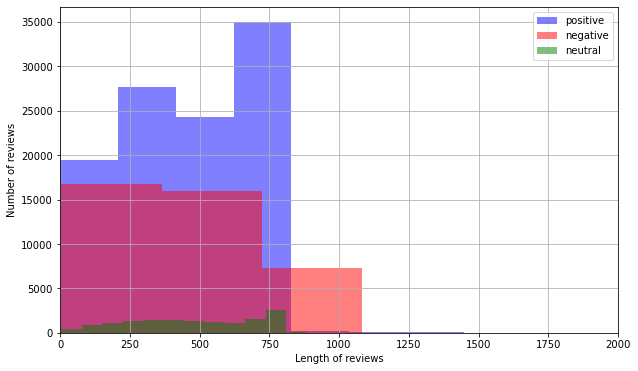

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histograms for each sentiment with different colors
colors = {'positive': 'blue', 'negative': 'red', 'neutral': 'green'}
for sentiment, color in colors.items():
    df[df['sentiment'] == sentiment]['length'].hist(alpha=0.5, bins=30, color=color,
                                                    label=sentiment, ax=ax)
ax.set_xlabel('Length of reviews')
ax.set_ylabel('Number of reviews')
ax.legend()
ax.set_xlim(0, 2000)
plt.show()

It appears from the graph that more positive and neutral reviews tend to be longer and more negative reviews tend to be shorter. However, we still cannot tell the difference only by the length the review since first, the data is unbalanced, and second, both positive and negative classes have a large number of instances within length 0 - 1000.

##### Look at reviews

Here is one example from the positive class and one from the negative class:

In [19]:
# An example of a positive review
df.loc[0].sentiment, df.loc[0, :].review

('positive',
 '"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"')

In [20]:
# An example of a negative review
df.loc[8].sentiment, df.loc[8, :].review

('negative',
 '" I Ve had  nothing but problems with the Keppera : constant shaking in my arms &amp; legs &amp; pins &amp; needles feeling in my arms &amp; legs severe light headedness no appetite &amp; etc."')

Use WordCloud to visualize most common words used in postive and negative reviews

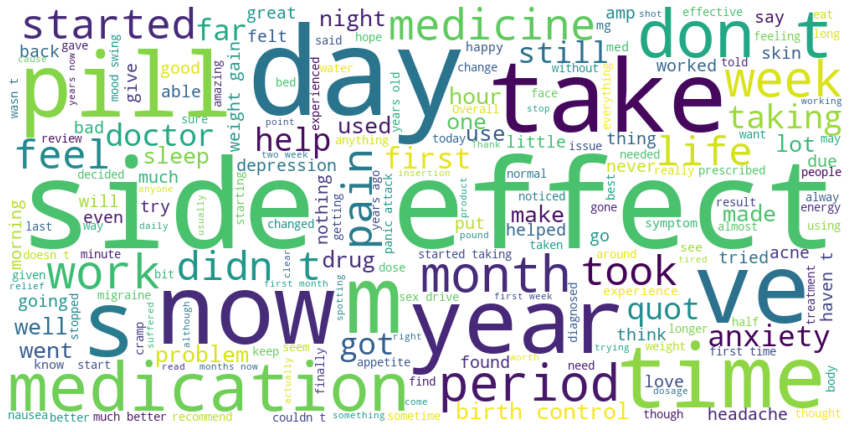

In [21]:
# Frequency of words in positive reviews
df_pos = df.loc[df.sentiment == 'positive', 'review']
k = (' '.join(df_pos))

wordcloud = WordCloud(width = 1000, height = 500, background_color = 'white').generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

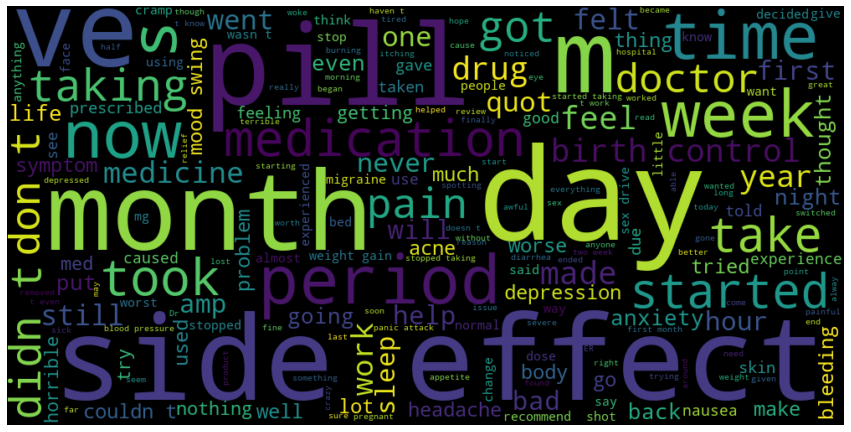

In [23]:
# Frequency of words in negative reviews
df_neg = df.loc[df.sentiment == 'negative', 'review']
k = (' '.join(df_neg))

wordcloud = WordCloud(width = 1000, height = 500, background_color = 'black').generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

Looking at the two samples and the word clouds, I find that the review text is messy and requires some cleaning. Other than that, certain words like "side effect" and "pill" are frequent in both word clouds, but the emotions assciated with them should be very different.

<h4> 2.2 Data Cleaning

2.2.1 Data type conversions and invalid data removal

##### Check for feature types and make appropriate type **conversion**

In [22]:
df.dtypes

drugName     object
condition    object
review       object
rating        int64
sentiment    object
length        int64
dtype: object

In [23]:
df = df.astype({'drugName':'string','condition':'string', 'review':'string'})
df.dtypes

drugName     string
condition    string
review       string
rating        int64
sentiment    object
length        int64
dtype: object

##### Check and remove invalid values

In [24]:
df.isnull().sum()

drugName       0
condition    899
review         0
rating         0
sentiment      0
length         0
dtype: int64

In [25]:
df = df[~df['condition'].isna()]
df.isnull().sum()

drugName     0
condition    0
review       0
rating       0
sentiment    0
length       0
dtype: int64

In [26]:
# Look at possible invliad drug names
df[df['drugName'].str.contains(r'[^\w\s()\/,#\']+', regex=True)]['drugName']

11                         L-methylfolate
85                          Nature-Throid
92        Monistat 7-Day Combination Pack
93                        Plan B One-Step
133                          Depo-Provera
                       ...               
161143                       Tri-Previfem
161193                       Tri-Sprintec
161240                        Synvisc-One
161274                        Synvisc-One
161291                     Junel 1.5 / 30
Name: drugName, Length: 4121, dtype: string

Drug names appear to be all valid, even with some special characters.

In [27]:
# Look at condition
df['condition'].value_counts()

Birth Control                                  28788
Depression                                      9069
Pain                                            6145
Anxiety                                         5904
Acne                                            5588
                                               ...  
Cyclitis                                           1
76</span> users found this comment helpful.        1
Strabismus                                         1
Occipital Neuralgia                                1
Neutropenia                                        1
Name: condition, Length: 884, dtype: Int64

From value_counts() I find that there are some invalid conditions for drugs, so I take a look at conditions that contain certain special characters, excluding "'", ",", "-", "/" as they can be in valid conditions.

In [28]:
df = df[~df["condition"].str.contains(r'[^a-zA-Z0-9\s\'\,\-\/]+')]
df['condition'].head(20)

0     Left Ventricular Dysfunction
1                             ADHD
2                    Birth Control
3                    Birth Control
4                Opiate Dependence
5     Benign Prostatic Hyperplasia
6          Emergency Contraception
7                  Bipolar Disorde
8                         Epilepsy
9                    Birth Control
10             Migraine Prevention
11                      Depression
12                 Crohn's Disease
13                           Cough
14                   Birth Control
15                         Obesity
16         Urinary Tract Infection
17                     ibromyalgia
18                 Bipolar Disorde
19    Chronic Myelogenous Leukemia
Name: condition, dtype: string

In [29]:
df.shape

(159237, 6)

##### Check and drop duplicate reviews

In [30]:
df  = df.drop_duplicates(keep="first", subset='review')
df.shape

(111134, 6)

In [31]:
df.reset_index(drop=True, inplace=True)

In [32]:
df['sentiment'].value_counts()

positive    73758
negative    27519
neutral      9857
Name: sentiment, dtype: int64

2.2.2 Balance the dataset

The dataset contains a high proportion of positive class, so if we use the dataset directly, the models will not learn well on the class with fewer samples. In addition, due to the size of the original dataset, I will choose the same number of instances from both positive and negative classes for modeling.

In [33]:
# Drop neutral class
df = df[df['sentiment'] != 'neutral']

# Separate instances for each class
df_negative = df[df['sentiment'] == 'negative']
df_positive = df[df['sentiment'] == 'positive']

df_negative_downsampled = resample(df_negative, replace=False, 
                                   n_samples=10000, random_state=42)

# Downsample the "positive" class to match the number of instances in the "negative" class
df_positive_downsampled = resample(df_positive, replace=False, 
                                   n_samples=10000, random_state=42)
                                   
df_balanced = pd.concat([df_negative_downsampled, df_positive_downsampled])

# Shuffle the dataset to randomize the order of instances
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

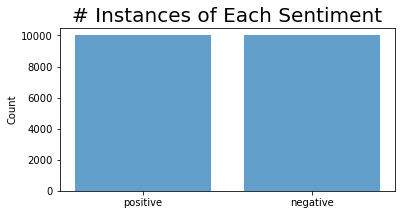

In [34]:
# Display the resampled data
sentiments = df_balanced['sentiment'].value_counts()
labels = sentiments.index
counts = sentiments.values

plt.rcParams['figure.figsize'] = (6, 3)
plt.bar(np.arange(len(labels)), counts, align='center', alpha=0.7)
plt.xticks(np.arange(len(labels)), labels)
plt.ylabel('Count')
plt.title('# Instances of Each Sentiment', fontsize=20)
plt.show()

Now the samples are balanced, so the modeling will much less likely to biased.

2.2.3 Text preprocessing

In [35]:
df_balanced.head()

,drugName,condition,review,rating,sentiment,length
0,Alesse,Birth Control,"""This is my first birth control pill and I hav...",10,positive,758
1,Lo Loestrin Fe,Birth Control,"""I used the medication for one month and durin...",4,negative,148
2,Ethinyl estradiol / levonorgestrel,Birth Control,"""After using various generic lo ovral like bir...",1,negative,420
3,Norethindrone,Birth Control,"""I have never taken birth control pills before...",4,negative,488
4,Scopolamine,Motion Sickness,"""Took it for 2 day cruise. Put it on in the mo...",10,positive,518


In [36]:
# Convert sentiments to binary labels
df_balanced['label'] = df_balanced['sentiment'].map({'positive':1,'negative':0})
df_balanced.head()

,drugName,condition,review,rating,sentiment,length,label
0,Alesse,Birth Control,"""This is my first birth control pill and I hav...",10,positive,758,1
1,Lo Loestrin Fe,Birth Control,"""I used the medication for one month and durin...",4,negative,148,0
2,Ethinyl estradiol / levonorgestrel,Birth Control,"""After using various generic lo ovral like bir...",1,negative,420,0
3,Norethindrone,Birth Control,"""I have never taken birth control pills before...",4,negative,488,0
4,Scopolamine,Motion Sickness,"""Took it for 2 day cruise. Put it on in the mo...",10,positive,518,1


In [37]:
df_cleaned = df_balanced[['review', 'sentiment', 'label']]
df_cleaned.head()

,review,sentiment,label
0,"""This is my first birth control pill and I hav...",positive,1
1,"""I used the medication for one month and durin...",negative,0
2,"""After using various generic lo ovral like bir...",negative,0
3,"""I have never taken birth control pills before...",negative,0
4,"""Took it for 2 day cruise. Put it on in the mo...",positive,1


In [38]:
def decontracted(phrase):
    """
    Expand the contracted phrase into normal words
    """
    phrase = re.sub(r"&#039;", "'", phrase)
    phrase = re.sub(r"&amp;", "and", phrase)
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

def clean_text(df):
    """
    Clean the review texts
    """
    cleaned_review = []

    for review_text in df['review']:
        
        # expand the contracted words
        review_text = decontracted(review_text)
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #remove url 
        review_text = re.sub(r'https?://\S+|www\.\S+', '', review_text)
        
        #Removing punctutation, string.punctuation in python consists of !"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~`
        review_text = review_text.translate(str.maketrans('', '', string.punctuation))
        
        # remove emails
        review_text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", '', review_text)
    
        cleaned_review.append(review_text)

    return cleaned_review

df_cleaned['cleaned_review'] = clean_text(df_cleaned)
df_cleaned.head()

C:\Users\18973\AppData\Local\Temp\ipykernel_15584\1844780737.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cleaned_review'] = clean_text(df_cleaned)


,review,sentiment,label,cleaned_review
0,"""This is my first birth control pill and I hav...",positive,1,This is my first birth control pill and I hav...
1,"""I used the medication for one month and durin...",negative,0,I used the medication for one month and durin...
2,"""After using various generic lo ovral like bir...",negative,0,After using various generic lo ovral like bir...
3,"""I have never taken birth control pills before...",negative,0,I have never taken birth control pills before...
4,"""Took it for 2 day cruise. Put it on in the mo...",positive,1,Took it for day cruise Put it on in the mo...


<h3> 3. Modeling and Evaluation

In [39]:
# define stopwords list
# Exluding NO, NOR, NOT from the stop words as they play keyrole
STOP = set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't", "st", "nd", "rd", 'day', 'year', 'month', 'now', 'pill', 'take', 'taking', \
            'doctor', 'medicine', 'medication', 'make', 'making', 'feel', 'felt'])

I use tfidf vectorizer to vectorize the review text for analysis, as it not only focuses on the frequency but also the importance of words.

In [40]:
vectorizer = TfidfVectorizer(lowercase=True, stop_words=STOP)

<h5> Train Test Split

* Randomly choose 80% as the training data, 20% as testing

In [41]:
X = df_cleaned.cleaned_review
y = df_cleaned.label

In [42]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2,
                                                 shuffle=True,
                                                 random_state=42)
# check data size after splitting
print("Training data: X : {}, y : {}".format(X_train.shape, y_train.shape))
print("Testing data: X : {}, y : {}".format(X_test.shape, y_test.shape))
# After train test split, we get 8000 samples in the training set and 2000 in the testing set.

Training data: X : (16000,), y : (16000,)
Testing data: X : (4000,), y : (4000,)


<h4> 3.1 Logistic Regression </h4>

* The first model I employ is logistic regression models the relationship between the features and the labels using a linear function, which means that it can learn a simple decision boundary that separates the two classes in the input space, thus making it good for binary classification.

3.1.1 Modeling and parameter tuning

In [43]:
lr_clf = LogisticRegression(solver='liblinear')

Setting the solver='liblinear' as it can be applied to both l1 and l2 regularization

* Parameter tuning
    * TfidfVectorizer:
        * max_df: controls the maximum frequency of occurrence of a term in the corpus beyond which it is ignored. If max_df is set to 0.8, any word that occurs in more than 80% corpus will be ignored.
        * ngram_range: the range of n-grams to include in the feature matrix. I'm interested in unigrams, bigrams, and trigrams.
    * Logistic Regression:
        * C: controls the regularization strength of the model. A smaller value of C results in stronger regularization. Regularization helps prevent overfitting by adding a penalty term to the loss function.
        * penalty: determines the type of regularization used in the model. L1 regularization can set many coefficients to zero, while L2 regularization produces models with smaller coefficients overall. I'm interested in the types of regularization as well as the strength if it, since they are directly related to model performance.

In [44]:
# build a pipeline
pipe_0 = Pipeline(steps = [
       ('vectorizer', vectorizer),
       ('classifier', lr_clf)])

param_grid_0 = {
    'vectorizer__max_df': [0.8, 0.9],
    'vectorizer__ngram_range': [(1,1), (2,2), (3,3)],
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2']
    }

In [45]:
search_result_0 = GridSearchCV(pipe_0, param_grid_0, cv=5, n_jobs=-1)

In [46]:
search_result_0.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'an', 'and',
                                                                    'any',
                                                                    'are',
                                                                    'aren',
    

3.1.2 Evaluation

In [47]:
search_result_0.best_params_

{'classifier__C': 1,
 'classifier__penalty': 'l2',
 'vectorizer__max_df': 0.8,
 'vectorizer__ngram_range': (1, 1)}

The best parameters for TfidfVectorizer are max_df = 0.8, ngram_range = (1,1), and C for LR = 1, and penalty is l2. This means that the model performs best when words that occur in 80% of the corpus are ignored, unigrams are included in the bag of words, the strength of regularization for LR is 1, and the type of regularization is l2.

In [48]:
best_model_0 = search_result_0.best_estimator_

In [49]:
y_pred = best_model_0.predict(X_test)
y_pred_prob = best_model_0.predict_proba(X_test)[:, 1]

In [50]:
print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.82      0.83      0.82      2055
    positive       0.81      0.81      0.81      1945

    accuracy                           0.82      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.82      0.82      0.82      4000



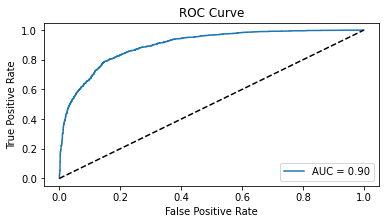

In [51]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr,
         label="AUC = {0:0.2f}"
         ''.format(roc_auc))
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

The ROC curve has an AUC of 0.90, which indicates that the classifier has a high true positive rate and a low false positive rate, meaning that it can effectively differentiate between the positive and negative classes.

Error Analysis

In [52]:
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [53]:
unmatch_df = pd.concat([X_test, y_test, pd.Series(y_pred)], axis=1)
unmatch_df.columns = ['review', 'label', 'predicted_label']

# Samples that are failed to be predicted by the model
unmatch_df = unmatch_df[unmatch_df['label'] != unmatch_df['predicted_label']]
unmatch_df.reset_index(drop=True, inplace=True)
# Show one example of one review in the negative class but predicted to be positive
unmatch_df.loc[0,:].review, unmatch_df.loc[0,:].label, unmatch_df.loc[0,:].predicted_label

(' Doctor prescribed me Prozac and asked that I attend group therapy to help any underlying issues  My depression came out in the form of anger   EVERYTHING annoyed me for no reason       At first  I felt no different taking the medication  After a few months  my brother was the person to realize that it was working  He pointed out that we had been getting along and very little seemed to annoy me anymore        Side effects  I was in a haze  For example  I would be driving and could completely miss the street I was suppose to turn on to and would not realize it until   miles later  Most people describe themselves as a zombie in this haze       With Prozac and therapy  I was on Prozac for about a year  ',
 1,
 0)

In [56]:
unmatch_df.loc[3,:].review, unmatch_df.loc[3,:].label, unmatch_df.loc[3,:].predicted_label

(' Really did not do much for anxiety or sleep for me personally   I do have a fairly high sedation tolerance however  ',
 0,
 1)

The first review itself is ambiguous and it contains words such as "depression" and "annoyed" that may have resulted in its being classified as negative.
The second review contains descriptions of physical state after taking the medicine that may have resulted in its being classified as positive.

Confusion Matrix:

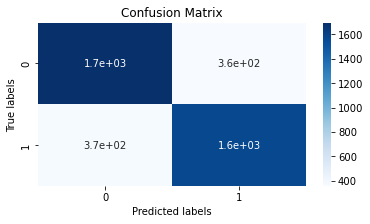

In [57]:
cm = confusion_matrix(y_test.tolist(), y_pred.tolist())

# plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

<h4> 3.2 Multinomial Naive Bayes</h4>

* I choose multinomial naive bayes as it is the best naive bayes model for text classification.

3.2.1 Modeling and parameter tuning

In [58]:
nb_clf = MultinomialNB()

* Parameter tuning
    * TfidfVectorizer:
        * The same as the previous model
    * Multinomial NB classifier:
        * alpha: additive (Laplace/Lidstone) smoothing parameter. It is to increase the probabilities of n-grams by 1 to make everything non-zero.
        * fit_prior: whether to learn class prior probabilities or not. When classes are balanced, setting the prior probabilities to uniform can prevent the algorithm from overfitting.

In [59]:
# build a pipeline
pipe_1 = Pipeline(steps = [
       ('vectorizer', vectorizer),
       ('classifier', nb_clf)])

param_grid_1 = {
    'vectorizer__max_df': [0.8, 0.9],
    'vectorizer__ngram_range': [(1,1), (2,2), (3,3)],
    'classifier__alpha': [1, 10, 100],
    'classifier__fit_prior': [True, False]
    }

In [60]:
search_result_1 = GridSearchCV(pipe_1, param_grid_1, cv=5, n_jobs=-1)

In [61]:
search_result_1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'an', 'and',
                                                                    'any',
                                                                    'are',
                                                                    'aren',
    

3.2.2 Evaluation

In [62]:
search_result_1.best_params_

{'classifier__alpha': 1,
 'classifier__fit_prior': True,
 'vectorizer__max_df': 0.8,
 'vectorizer__ngram_range': (2, 2)}

The best parameters for TfidfVectorizer and Multinomial Naive Bayes are max_df = 0.8, ngram_range = (2,2), alpha for MNB = 1, and fit_prior = True. This means that the model performs best when words that occur in 80% of the corpus are ignored, bigrams are included in the bag of words, smoothing parameter for MNB is 1, and the class prior probability to True (here since half the instances are positive and half negative, class prior probabiility is true or false is essentially the same).

In [63]:
best_model_1 = search_result_1.best_estimator_

In [64]:
y_pred = best_model_1.predict(X_test)
y_pred_prob = best_model_1.predict_proba(X_test)[:, 1]

In [65]:
print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.81      0.84      0.82      2055
    positive       0.82      0.79      0.81      1945

    accuracy                           0.82      4000
   macro avg       0.82      0.81      0.81      4000
weighted avg       0.82      0.82      0.82      4000



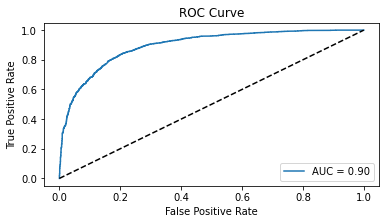

In [66]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr,
         label="AUC = {0:0.2f}"
         ''.format(roc_auc))
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

The ROC curve has an AUC of 0.90, which is similar to that of Logistic Regression model. It means the MNB model is also effective in differentiating between the positive and negative classes.

Error Analysis

In [67]:
unmatch_df = pd.concat([X_test, y_test, pd.Series(y_pred)], axis=1)
unmatch_df.columns = ['review', 'label', 'predicted_label']

# Samples that are failed to be predicted by the model
unmatch_df = unmatch_df[unmatch_df['label'] != unmatch_df['predicted_label']]
unmatch_df.reset_index(drop=True, inplace=True)
# Show one example of one review in the negative class but predicted to be positive
unmatch_df.loc[2,:].review, unmatch_df.loc[2,:].label, unmatch_df.loc[2,:].predicted_label

(' I have been on this medicine for a few months   Before my biggest problem was waking up at night to pee but not having enough time to get to the bathroom before it started running down my leg   The Sanctura alleviated this problem  and I have not experienced any negative side effects but it feels like it is harder to empty my bladder   It seems like my bladder is never really completely empty  but the Sanctura does help to eliminate  quot accidents  quot    ',
 1,
 0)

In [68]:
# Show one example of one review in the negative class but predicted to be positive
unmatch_df.loc[4,:].review, unmatch_df.loc[4,:].label, unmatch_df.loc[4,:].predicted_label

(' Tried several consecutive doses of guaifenesin syrup as an expectorant in the later stages of a cold   It may have lessened coughing slightly for a couple of hours after each dose  hard to tell    Definitely no detectable effect on the amount or consistency of the mucus I coughed up   But the syrup does taste very much like medicine  so the placebo effect is great  ',
 0,
 1)

The first review has descriptions of some symptoms after taking the medicine. The second one contains words like "great" and is itself ambiguous that may have led to the wrong classification.

Confusion Matrix:

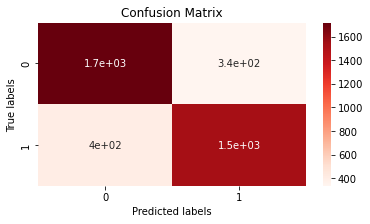

In [69]:
cm = confusion_matrix(y_test.tolist(), y_pred.tolist())

# plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Reds')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

<h4> 3.3 SGDClassifier </h4>

* SGDClassifier is good with large datasets especially when the data is sparse, so I use SGDClassifier rather than SVC. Setting the parameter "loss='**hinge**'" makes it basically the same as using SVC.

3.3.1 Modeling and parameter tuning

In [70]:
sgdc_clf = SGDClassifier(loss='hinge')

* Parameter Tuning
    * TfidfVectorizer:
        * The same as the previous model.
    * SGDClassifier
        * penalty: type of regularizations to be applied to the weights of the model, including l1, l2, and a combination of l1 and l2, to prevent overfitting.
        * alpha: the strength of regularization penalty applied to the weights. A larger alpha corresponds to a stronger regularization that may prevent overfitting but may increase the bias.

In [71]:
# build a pipeline
pipe_2 = Pipeline(steps = [
       ('vectorizer', vectorizer),
       ('classifier', sgdc_clf)])

param_grid_2 = {
    'vectorizer__max_df': [0.8, 0.9],
    'vectorizer__ngram_range': [(1,1), (2,2), (3,3)],
    'classifier__penalty': ['l2', 'l1', 'elasticnet'],
    'classifier__alpha': [0.0001, 0.001, 0.01]
}

In [72]:
search_result_2 = GridSearchCV(pipe_2, param_grid_2, cv=5, n_jobs=-1)

In [73]:
search_result_2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'an', 'and',
                                                                    'any',
                                                                    'are',
                                                                    'aren',
    

3.3.2 Evaluation

In [74]:
search_result_2.best_params_

{'classifier__alpha': 0.0001,
 'classifier__penalty': 'elasticnet',
 'vectorizer__max_df': 0.9,
 'vectorizer__ngram_range': (1, 1)}

The best parameters for TfidfVectorizer are max_df = 0.9 and ngram_range = (1,1) and SGDClassifier is alpha = 0.0001 and penalty = elasticnet. This means that The model performs the best when words that occur in 90% of the corpus are excluded (more words are considered compared to previous models), the words in the feature matrix are individual words (unigrams), and a small regularization on elasticne (combines l1 and l2). 

In [75]:
best_model_2 = search_result_2.best_estimator_

Probability estimates are not directly available for binary classifiers that use the "hinge" loss function, as the "hinge" loss function is a margin-based loss function that tries to maximize the distance between the decision boundary and the closest training samples, without providing probability estimates of the predicted class. Thus, I find the decision function to find the probabilities.

In [96]:
y_pred = best_model_2.predict(X_test)
y_pred_prob = best_model_2.decision_function(X_test)
y_pred_prob = pd.Series(y_pred_prob)

In [77]:
print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.82      0.83      0.82      2055
    positive       0.82      0.81      0.81      1945

    accuracy                           0.82      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.82      0.82      0.82      4000



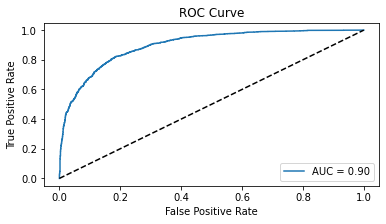

In [78]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr,
         label="AUC = {0:0.2f}"
         ''.format(roc_auc))
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

The ROC curve has an AUC of 0.87, which is similarto the above two models. It means the SGD classifier model is also effective in differentiating between the positive and negative classes.

Error Analysis

In [97]:
unmatch_df = pd.concat([X_test, y_test, pd.Series(y_pred)], axis=1)
unmatch_df.columns = ['review', 'label', 'predicted_label']

# Samples that are failed to be predicted by the model
unmatch_df = unmatch_df[unmatch_df['label'] != unmatch_df['predicted_label']]
unmatch_df.reset_index(drop=True, inplace=True)
# Show one example of one review in the negative class but predicted to be positive
unmatch_df.loc[6,:].review, unmatch_df.loc[6,:].label, unmatch_df.loc[6,:].predicted_label

(' My wife altzheimer  extreme anxiety episodes   mdash Notable improvement after dosage change mdash  ',
 1,
 0)

In [80]:
unmatch_df.loc[9,:].review, unmatch_df.loc[9,:].label, unmatch_df.loc[9,:].predicted_label

(' I suffer from chronic migraines and a lot of the time need an abort medicine  This medicine did get rid of my headache  BUT it will make you feel like you got hit by a bus  You will be incredibly achy and will wish you still had a headache migraine  My whole body would hurt for hours after taking this  I would not recommend it to anyone  I take naratriptan  amerge  and I do not get achy at all and it knocks out my migraine just the same  ',
 0,
 1)

The first review is possibly mislabeled because it contains phrases like "extreme anxiety". The second one possibly because it has comparisons between medicines.

Confusion Matrix:

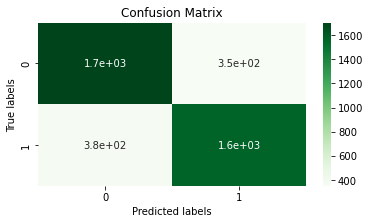

In [81]:
cm = confusion_matrix(y_test.tolist(), y_pred.tolist())

# plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Greens')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

<h4> 3.4 Recurrent Neural Networks (Explorations) </h4>

* RNNs are a popular choice for text classification tasks, as they are able to capture sequential information and long-term dependencies in text data.

* One common architecture for RNN-based text classification is the Long Short-Term Memory (LSTM) network, which uses a memory cell and a set of gates to selectively forget or remember information at each time step.

In [82]:
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer # A text tokenizer to vectorize a text corpus
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Embedding, Flatten, Dense, SimpleRNN, Activation, Embedding, LSTM, Bidirectional #The applicable layers used in RNN model

3.4.1 Modeling

To use an RNN for text classification, the input text data is typically encoded as sequences of word embeddings. The word embeddings are then fed into the RNN, which processes them sequentially to produce a final output vector. 

In [83]:
tokenizer = Tokenizer(num_words=200)
tokenizer.fit_on_texts(X_train)

# Convert reviews to integer sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

print("Train sequences:")
print(train_sequences[0])

# Padding the sequences to get an equal length
maxlen = 100
train_sequences = preprocessing.sequence.pad_sequences(train_sequences, maxlen = maxlen)
test_sequences = preprocessing.sequence.pad_sequences(test_sequences, maxlen = maxlen)

# After padding:
print("\nTrain sequences after padding:")
print(train_sequences[0])

Train sequences:
[1, 78, 6, 144, 16, 140, 47, 123, 10, 133, 4, 139, 5, 16, 11, 100, 25, 3, 44, 27, 3, 36, 78, 2, 1, 20, 188, 23, 6, 38, 87, 24, 14, 13, 5, 11, 5, 74, 99, 25, 3, 44, 102, 47, 1, 6, 166, 11, 51, 7, 15, 6, 65, 2, 1, 18, 56, 80, 3, 66, 23, 1, 20, 10, 62, 21, 11, 131, 5, 59, 62, 6, 119, 56, 32, 94, 3, 3, 47, 21, 1, 151, 139, 6, 88, 14, 38, 24, 129, 1, 172, 1, 61, 60, 3, 41, 54, 19, 1, 61, 10, 54, 1, 172, 3, 13, 4, 10, 4, 49, 155, 56, 4, 53]

Train sequences after padding:
[ 11 100  25   3  44  27   3  36  78   2   1  20 188  23   6  38  87  24
  14  13   5  11   5  74  99  25   3  44 102  47   1   6 166  11  51   7
  15   6  65   2   1  18  56  80   3  66  23   1  20  10  62  21  11 131
   5  59  62   6 119  56  32  94   3   3  47  21   1 151 139   6  88  14
  38  24 129   1 172   1  61  60   3  41  54  19   1  61  10  54   1 172
   3  13   4  10   4  49 155  56   4  53]


Then build the RNN model:

In [84]:
model = Sequential()
model.add(Embedding(200, 16, input_length=maxlen))  # 5000 as the input dimension, 
      # 16 as the output dimension, and input_length as the maximum length of the input sequences
model.add(Bidirectional(LSTM(16, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(16, dropout=0.2, recurrent_dropout=0.2)))  # add two bidirectional LSTM layers
model.add(Dense(3, activation='sigmoid'))   # adds a dense layer with 3 units and sigmoid for binary classification

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           3200      
                                                                 
 bidirectional (Bidirectiona  (None, 100, 32)          4224      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 13,795
Trainable params: 13,795
Non-trainable params: 0
_________________________________________________________________


In [85]:
# Compiling the models
model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['acc']) 

In [87]:
# Training the model
history = model.fit(train_sequences, y_train, 
                    epochs = 10,
                    batch_size = 64, 
                    validation_split = 0.2)

Epoch 1/10
200/200 [==============================] - 35s 144ms/step - loss: 0.7150 - acc: 0.5186 - val_loss: 0.6661 - val_acc: 0.6453
Epoch 2/10
200/200 [==============================] - 27s 136ms/step - loss: 0.6053 - acc: 0.6807 - val_loss: 0.5611 - val_acc: 0.7172
Epoch 3/10
200/200 [==============================] - 28s 139ms/step - loss: 0.5600 - acc: 0.7148 - val_loss: 0.5387 - val_acc: 0.7322
Epoch 4/10
200/200 [==============================] - 28s 139ms/step - loss: 0.5387 - acc: 0.7346 - val_loss: 0.5383 - val_acc: 0.7281
Epoch 5/10
200/200 [==============================] - 28s 139ms/step - loss: 0.5306 - acc: 0.7394 - val_loss: 0.5534 - val_acc: 0.7256
Epoch 6/10
200/200 [==============================] - 28s 140ms/step - loss: 0.5248 - acc: 0.7413 - val_loss: 0.5352 - val_acc: 0.7300
Epoch 7/10
200/200 [==============================] - 29s 146ms/step - loss: 0.5186 - acc: 0.7461 - val_loss: 0.5223 - val_acc: 0.7375
Epoch 8/10
200/200 [==============================] - 2

Train the RNN model with training sequences that I converted before and the training y, with the five iteration over the dataset (epochs=5). It trains 64 examples at a time (faster than 32) and randomly selects 20% of the training data as a validation set to monitor model performance.

3.4.2 Evaluation

Use the model to predict the test sequences and labels:

In [88]:
y_pred = model.predict(test_sequences)
y_pred = np.argmax(y_pred, axis=1)
y_pred

125/125 [==============================] - 5s 31ms/step


array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

In [89]:
y_pred_proba = expit(y_pred)

In [90]:
print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.74      0.80      0.77      2055
    positive       0.77      0.70      0.73      1945

    accuracy                           0.75      4000
   macro avg       0.75      0.75      0.75      4000
weighted avg       0.75      0.75      0.75      4000



It is worth noting that the f1-score for the positive class is 0.73 versus negative class of 0.77, which means the model performance on predicting positive instances is not very good. This may be because the dataset is relatively too small for such model or I did'nt tune the model parameters well or add enough layers.

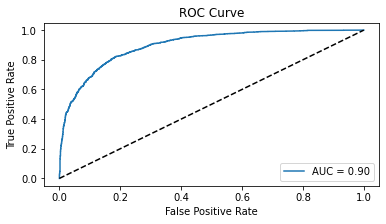

In [91]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr,
         label="AUC = {0:0.2f}"
         ''.format(roc_auc))
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

The ROC curve has an AUC of 0.90, which indicates the RNN model is effective in differentiating between classes.

Error Analysis

In [92]:
unmatch_df = pd.concat([X_test, y_test, pd.Series(y_pred)], axis=1)
unmatch_df.columns = ['review', 'label', 'predicted_label']

# Samples that are failed to be predicted by the model
unmatch_df = unmatch_df[unmatch_df['label'] != unmatch_df['predicted_label']]
unmatch_df.reset_index(drop=True, inplace=True)
# Show one example of one review in the negative class but predicted to be positive
unmatch_df.loc[6,:].review, unmatch_df.loc[6,:].label, unmatch_df.loc[6,:].predicted_label

(' My wife altzheimer  extreme anxiety episodes   mdash Notable improvement after dosage change mdash  ',
 1,
 0)

In [93]:
unmatch_df.loc[1,:].review, unmatch_df.loc[1,:].label, unmatch_df.loc[1,:].predicted_label

(' Literally could only tolerate it for three days before removing it  Was getting headaches  could not sleep  had an anxiety attack out of nowhere and the brown discharge was gross plus it made my vag sore and itchy  I guess it is one of those things that you really like or just can not stand  If it works for you run with it but if you have symptoms from what I have read be prepared to have those symptoms for at least a month  Ca not say it does not do it is job but are the side effects worth it  ',
 0,
 1)

Confusion Matrix:

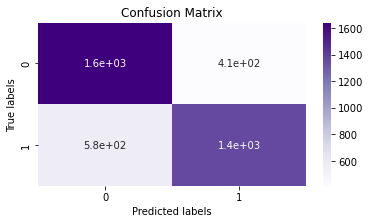

In [94]:
cm = confusion_matrix(y_test.tolist(), y_pred.tolist())

# plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Purples')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

From the matrix we can observe that the RNN model is not very effective in differentiating the positive instances compared to negative instances.

<h3> 4. Evaluation Summary and Conclusions </h3>


<h4> Model Summary </h4>

**Best Parameters:**
1. Logistic Regression:
* 'classifier__C': 1
* 'classifier__penalty': 'l2'
* 'vectorizer__max_df': 0.8
* 'vectorizer__ngram_range': (1, 1)

2. Multinomial Naive Bayes:
* 'classifier__alpha': 1
* 'classifier__fit_prior': True
* 'vectorizer__max_df': 0.8
* 'vectorizer__ngram_range': (2, 2)

3. SGD Classifier:
* 'classifier__alpha': 0.0001
* 'classifier__penalty': 'elasticnet'
* 'vectorizer__max_df': 0.9
* 'vectorizer__ngram_range': (1, 1)


**Classification Report Summary:**

In [95]:
scores = {'Model': ['Logistic Regression', 'Multinomial Naive Bayes', 'SGD Classifier', 'Recurrent Neural Network'],
          'F1-Score': ['N: 0.82, P: 0.81', 'N: 0.82, P: 0.81', 'N: 0.82, P: 0.81', 'N: 0.77, P: 0.73'],
          'AUC Score': ['0.90', '0.90', '0.90', '0.90']}
table = pd.DataFrame(scores)
table

,Model,F1-Score,AUC Score
0,Logistic Regression,"N: 0.82, P: 0.81",0.90
1,Multinomial Naive Bayes,"N: 0.82, P: 0.81",0.90
2,SGD Classifier,"N: 0.82, P: 0.81",0.90
3,Recurrent Neural Network,"N: 0.77, P: 0.73",0.90


The three traditional ML models all have similar performances on the dataset and high f1 and AUC scores. The neural network model has a relatively high AUC score but has moderate f1 scores compared to other models, especially the f1 score for the positive class, possibly due to the dataset size and the lack of parameter tuning.

**Error Analysis:**

The classification is prone to be wrong when the review has descriptions of comparison of symptoms before and after using the medicine or contains certain words with sentiment that do not directly describe the effects of the medicine that may confuse the model.

<h4> Conclusion </h4>
I built 4 binary sentiment analysis models for the UCI Drug Review dataset: Logistic Regression, Multinomial Naive Bayes, SGD Classifier, and Recurrent Neural Network. 
The ML pipeline:

* Data analysis and pre-processing: cleaned and balanced the dataset. Pre-processed review text.
* Modeling and parameter tuning: split the data into 80% training and 20% testing. Used pipeline and grid search to find the best parameters for Tfidf vectorizer and the classification models.
* Model evaluations: used best-performace models' on testing data and showed classification reports, ROC curves, and confusion matrices. Showed snippets of mislabeled reviews in error analysis.
    
Overall, the traditional ML classification models work well on the dataset; logistic regression model has relatively the best performanace. 

Further research can be done by incorporating more data to acquire better scores, especially for the RNN model. Considering the running time of each model, I only used a small proportion of the original dataset. In addition, more explorations on the text can be done in order to achieve better deconstruction of data.